In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import config

In [3]:
# load data: from publications table
pubs = pd.read_csv(f'{config.project_path}/tables/topics_publications.csv')
pubs = pubs[~pd.isna(pubs['Topic number'])]
pubs['Topic number'] = pubs['Topic number'].astype(int)
# relations: harvested from scival
df = pd.read_csv(f'{config.project_path}/relations.csv')

In [4]:
# create a subset where we keep only topN topics, e.g. top100
n = 100
topN = pubs.groupby('Topic number').\
             agg(name = ('Topic name', 'first'), count = ('EID', 'count')).\
             sort_values('count', ascending=False).iloc[:n, :]

In [5]:
df_topN = df[df['topic_id'].isin(topN.index) &
               df['related_topic_id'].isin(topN.index)]

In [6]:
# for topics that don't have a relation with any of the other topics:
# create relation/edge with self
topN_no_relation = topN[~topN.index.isin(df_topN['topic_id']) & ~topN.index.isin(df_topN['related_topic_id'])]
df_topN_no_relation = []
for index, row in topN_no_relation.iterrows():
    df_topN_no_relation.append({
        'topic_id': index,
        'related_topic_id': index,
        'topic_name': row['name'],
        'related_topic_name': row['name'],
        'score': 1
    })
df_topN_no_relation = pd.DataFrame(df_topN_no_relation)
df_topN = pd.concat([df_topN, df_topN_no_relation])

Network visualisation
- nodes should be coloured according to the number of publications in our dataset
- each institute uses the same network (=seed), but node size/colour indicates specialisation

In [7]:
# only show labels for the largest topics, show IDs for others
# (with a legend/table next to it mapping ID to name?)
n_label = 10
labels = topN.copy()
labels['label'] = labels['name']
labels.loc[labels.index[n_label:], 'label'] = labels.index[n_label:]

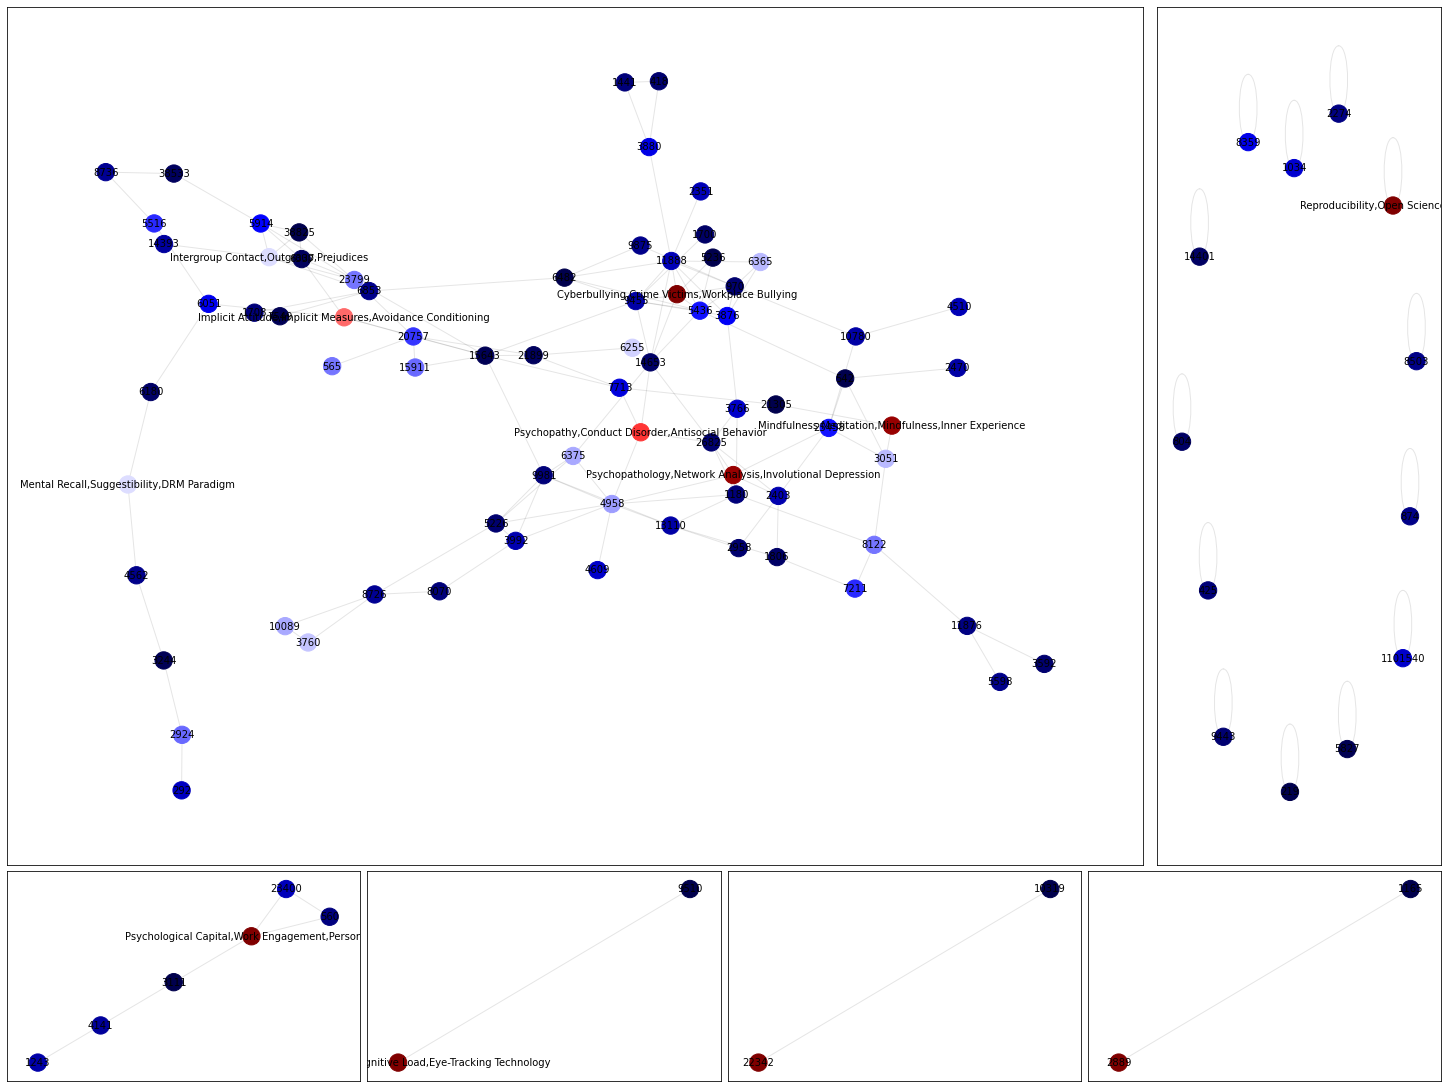

In [9]:
G = nx.Graph()

# initialise the network with all nodes (don't draw)
for i, row in df_topN.iterrows():
    G.add_edge(row['topic_id'], row['related_topic_id'])

# drawing function for subplots (s) and axis (ax)
def draw_subgraph(s, ax):
    pos = nx.spring_layout(s, seed=97615)
    nx.draw_networkx_nodes(s, pos, ax=ax, node_color=[topN.loc[n, 'count'] for n in pos], cmap='seismic')
    nx.draw_networkx_edges(s, pos, ax=ax, alpha=0.1)
    nx.draw_networkx_labels(s, pos, ax=ax, font_size=10,
                            labels={n:labels.loc[n, 'label'] for n in pos})

# get cluster components (sorted by number of connections)
cp = sorted(nx.connected_components(G), key=len, reverse=True)

cps = []  # list of components with > 1 connections (except largest)
cp1 = []  # new combined component containing all single nodes
for c in cp[1:]:
    if len(c) > 1:
        cps.append(c)
    else:
        cp1 += c

fig = plt.figure(constrained_layout=True, figsize=(20, 15))
# divide the plot into 2 subplots (1: large cluster + single nodes, 2: other clusters)
gs0 = gridspec.GridSpec(2, 1, height_ratios=[4,1], figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[4,1], subplot_spec=gs0[0])
gs01 = gridspec.GridSpecFromSubplotSpec(1, len(cps), subplot_spec=gs0[1])

# draw
# largest cluster
a0 = fig.add_subplot(gs00[0, 0])
draw_subgraph(G.subgraph(cp[0]), a0)
# single nodes
a1 = fig.add_subplot(gs00[0, 1])
draw_subgraph(G.subgraph(cp1), a1)
# other connected clusters
for i in range(len(cps)):
    a = fig.add_subplot(gs01[0, i])
    draw_subgraph(G.subgraph(cps[i]), a)

plt.savefig("../network.png", format="PNG")
plt.show()